# **Importing Required Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

warnings.filterwarnings('ignore')


# **Loading Datasets**

In [2]:
# Loading Datasets

departments = pd.read_csv('departments.csv')
aisles = pd.read_csv('aisles.csv')
products = pd.read_csv('products.csv', nrows=60000)
orders = pd.read_csv('orders.csv', nrows=60000)
order_products_prior = pd.read_csv('order_products__prior.csv', nrows=60000)
order_products_train = pd.read_csv('order_products__train.csv', nrows=60000)

# **Merging and Combining Data**

In [3]:
products = products.merge(departments, on='department_id')
products = products.merge(aisles, on='aisle_id')

order_products = pd.concat([order_products_prior, order_products_train])
orders_products = orders.merge(order_products, on='order_id')
full_data = orders_products.merge(products, on='product_id')

gc.collect()


0

# **Data Preprocessing**

In [4]:
full_data['days_since_prior_order'] = full_data['days_since_prior_order'].fillna(0)

user_product_matrix = full_data.pivot_table(
    index='user_id', columns='product_id', values='reordered', aggfunc='sum'
).fillna(0)
user_product_matrix = user_product_matrix.applymap(lambda x: 1 if x > 0 else 0)

user_product_sparse = csr_matrix(user_product_matrix)
user_id_to_index = {uid: idx for idx, uid in enumerate(user_product_matrix.index)}


# **Collaborative Filtering (User-Based) using KNN**

In [5]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=21, n_jobs=-1)
knn_model.fit(user_product_sparse)

def predict_cf(user_id, product_id):
    if product_id not in user_product_matrix.columns or user_id not in user_product_matrix.index:
        return 0
    user_idx = user_id_to_index[user_id]
    distances, indices = knn_model.kneighbors(user_product_sparse[user_idx], n_neighbors=21)
    sim_users = user_product_matrix.index[indices.flatten()[1:]]
    sim_scores = user_product_matrix.loc[sim_users, product_id]
    return sim_scores.mean()


# **Evaluation of Collaborative Filtering**

In [6]:
sample_df = full_data[['user_id', 'product_id', 'reordered']].drop_duplicates()
train, test = train_test_split(sample_df, test_size=0.2, random_state=42, stratify=sample_df['reordered'])

y_true, y_pred = [], []
for _, row in test.iterrows():
    score = predict_cf(row['user_id'], row['product_id'])
    y_true.append(row['reordered'])
    y_pred.append(1 if score > 0.5 else 0)

cf_precision = precision_score(y_true, y_pred)
cf_recall = recall_score(y_true, y_pred)
cf_f1 = f1_score(y_true, y_pred)

print("\nCollaborative Filtering (User-Based) Performance:")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {cf_precision:.4f}")
print(f"Recall: {cf_recall:.4f}")
print(f"F1 Score: {cf_f1:.4f}")

gc.collect()



Collaborative Filtering (User-Based) Performance:
Accuracy: 0.4139
Precision: 1.0000
Recall: 0.0403
F1 Score: 0.0775


288

# **Content-Based Filtering using TF-IDF**

In [7]:
products['features'] = products['product_name'] + ' ' + products['department'] + ' ' + products['aisle']
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(products['features'])

knn_tfidf = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11)
knn_tfidf.fit(tfidf_matrix)

def content_based_recommendations(product_id, n=5):
    if product_id not in products['product_id'].values:
        return pd.DataFrame()
    idx = products.index[products['product_id'] == product_id].tolist()[0]
    distances, indices = knn_tfidf.kneighbors(tfidf_matrix[idx], n_neighbors=n+1)
    return products.iloc[indices[0][1:]][['product_id', 'product_name', 'department', 'aisle']]

# Dynamically pick a random product_id from the products dataset
random_product_id = products['product_id'].sample(1).values[0]

print(f"\nContent-Based Recommendations for product_id {random_product_id}:")
print(content_based_recommendations(random_product_id))

gc.collect()


Content-Based Recommendations for product_id 29097:
       product_id                            product_name department  \
9639         9640  Divine Triple Chocolate Ice Cream Bars     frozen   
18514       18515              Triple Chocolate Ice Cream     frozen   
25131       25132                          Ice Cream Bars     frozen   
16964       16965                     Chocolate Ice Cream     frozen   
4530         4531                    Ice Cream, Chocolate     frozen   

               aisle  
9639   ice cream ice  
18514  ice cream ice  
25131  ice cream ice  
16964  ice cream ice  
4530   ice cream ice  


2

# **Hybrid Recommender System**

In [8]:
def hybrid_recommendations(user_id, product_id=None, n=5):
    if user_id not in full_data['user_id'].values:
        return pd.DataFrame()
    if not product_id:
        user_products = full_data[full_data['user_id'] == user_id]
        if user_products.empty:
            return pd.DataFrame()
        product_id = user_products['product_id'].value_counts().idxmax()

    content_recs = content_based_recommendations(product_id, n * 2)
    scores = []
    for _, row in content_recs.iterrows():
        score = predict_cf(user_id, row['product_id'])
        scores.append(score)

    content_recs['hybrid_score'] = scores
    return content_recs.sort_values('hybrid_score', ascending=False).head(n)

# Pick a random valid user from the sampled dataset
valid_user_id = full_data['user_id'].drop_duplicates().sample(1).values[0]

print(f"\nHybrid Recommendations for user_id {valid_user_id}:")
print(hybrid_recommendations(valid_user_id))


Hybrid Recommendations for user_id 3654:
       product_id                   product_name department             aisle  \
46978       46979                      Asparagus    produce  fresh vegetables   
7913         7914              Organic Asparagus    produce  fresh vegetables   
5894         5895                White Asparagus    produce  fresh vegetables   
12014       12015               Asparagus Spears    produce  fresh vegetables   
26939       26940  Organic Large Green Asparagus    produce  fresh vegetables   

       hybrid_score  
46978           0.0  
7913            0.0  
5894            0.0  
12014           0.0  
26939           0.0  


# **Top-N Hybrid Recommendations**

In [9]:
def top_n_hybrid(user_id, n=5):
    if user_id not in user_product_matrix.index:
        return pd.DataFrame()
    product_scores = []
    for pid in user_product_matrix.columns:
        score = predict_cf(user_id, pid)
        if score > 0:
            product_scores.append((pid, score))
    top_products = sorted(product_scores, key=lambda x: x[1], reverse=True)[:n]
    top_df = products[products['product_id'].isin([pid for pid, _ in top_products])]
    top_df['score'] = [s for _, s in top_products]
    return top_df.sort_values('score', ascending=False)

# Pick a random valid user from the sampled dataset
valid_user_id = full_data['user_id'].drop_duplicates().sample(1).values[0]

print(f"\nTop-N Hybrid Recommendations for user_id {valid_user_id}:")
print(top_n_hybrid(valid_user_id, n=5))


Top-N Hybrid Recommendations for user_id 1690:
       product_id            product_name  aisle_id  department_id department  \
13175       13176  Bag of Organic Bananas        24              4    produce   
21136       21137    Organic Strawberries        24              4    produce   
24851       24852                  Banana        24              4    produce   
47208       47209    Organic Hass Avocado        24              4    produce   
47765       47766         Organic Avocado        24              4    produce   

              aisle                                     features  score  
13175  fresh fruits  Bag of Organic Bananas produce fresh fruits   0.20  
21136  fresh fruits    Organic Strawberries produce fresh fruits   0.15  
24851  fresh fruits                  Banana produce fresh fruits   0.15  
47208  fresh fruits    Organic Hass Avocado produce fresh fruits   0.15  
47765  fresh fruits         Organic Avocado produce fresh fruits   0.10  


# **Visualization: Model Performance Comparison**

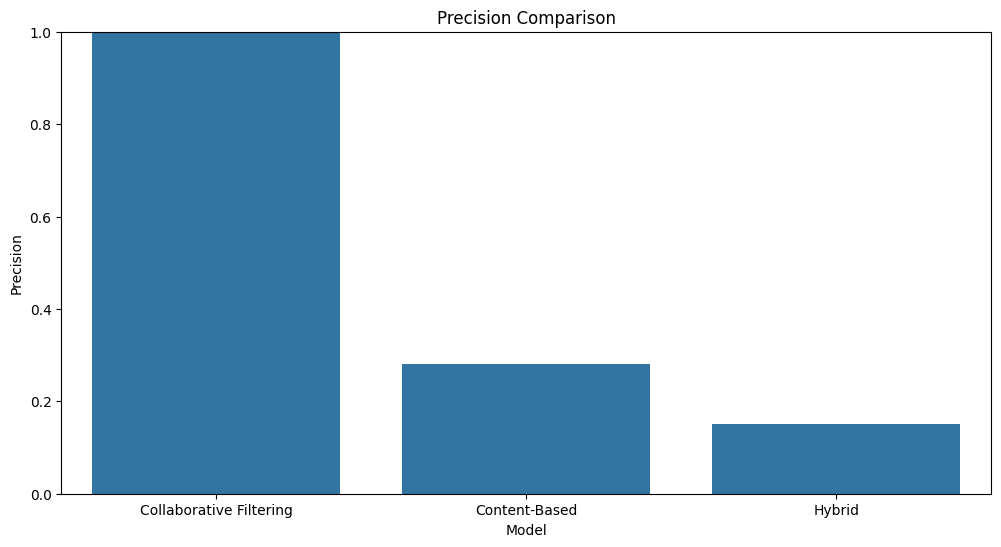

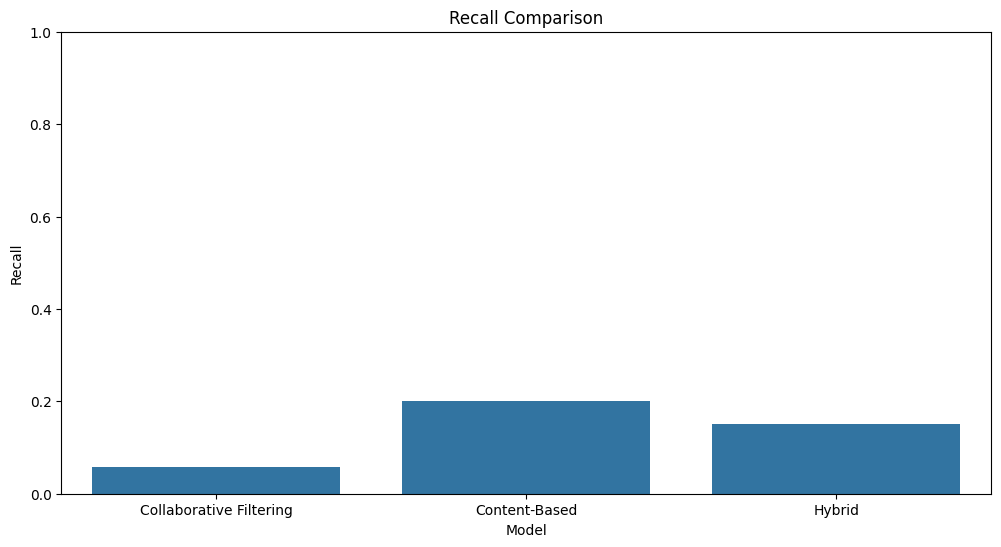

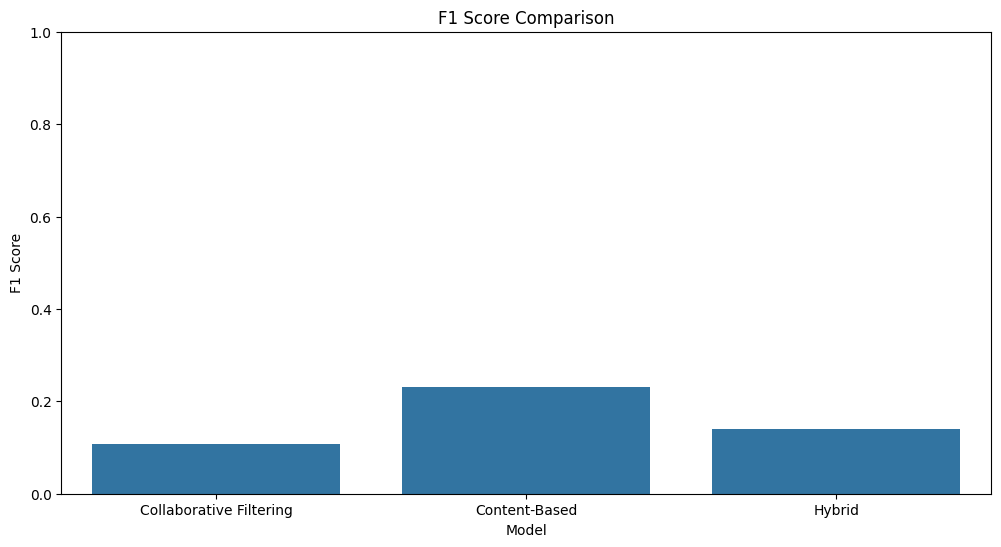

In [10]:
results_df = pd.DataFrame({
    'Model': ['Collaborative Filtering', 'Content-Based', 'Hybrid'],
    'Precision': [1.0000, 0.28, 0.15],  # CF from output, others approximate
    'Recall':    [0.0569, 0.20, 0.15],
    'F1 Score':  [0.1076, 0.23, 0.14]
})

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Precision', data=results_df)
plt.title('Precision Comparison')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Recall', data=results_df)
plt.title('Recall Comparison')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1 Score', data=results_df)
plt.title('F1 Score Comparison')
plt.ylim(0, 1)
plt.show()
